<a href="https://colab.research.google.com/github/jcjr64/CIND820/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas pdfplumber beautifulsoup4 requests tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 65.6 MB/s eta 0:00:00


In [ ]:
import pdfplumber
import pandas as pd
import glob
import re
from dateutil.parser import parse

In [ ]:
#Loading the Loughran-McDonald Master Dictionary

lm_dict = pd.read_csv('/content/Dict/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
positive_words = lm_dict[lm_dict['Positive'] > 0]['Word'].str.lower().tolist()
negative_words = lm_dict[lm_dict['Negative'] > 0]['Word'].str.lower().tolist()

In [ ]:
def extract_date_from_filename(file_name):
    date_pattern = '\d{4}-\d{2}-\d{2}'  # Adjust based on your file naming convention
    match = re.search(date_pattern, file_name)
    if match:
        return parse(match.group(0)).date()
    return None

In [ ]:
def parse_pdf(file_path):
    text = ''
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ''
    return text

In [ ]:
def analyze_sentiment(text):
    words = text.lower().split()
    pos_count = sum(word in positive_words for word in words)
    neg_count = sum(word in negative_words for word in words)
    return pos_count - neg_count  # Simple sentiment score: positive - negative

In [ ]:
def process_pdfs_in_directory(directory_path):
    results = []

    for file_path in glob.glob(f"{directory_path}/*.pdf"):
        file_name = file_path.split('/')[-1]
        date = extract_date_from_filename(file_name)
        text = parse_pdf(file_path)
        sentiment_score = analyze_sentiment(text)

        results.append({
            'file_name': file_name,
            'date': date,
            'sentiment_score': sentiment_score,
            'average_sentiment_score': sentiment_score  # Since we're treating the entire PDF as a single unit
        })

    return results

In [ ]:
pdf_directory = '/content/SECdated'  # Replace with the actual path to your PDF files
pdf_results = process_pdfs_in_directory(pdf_directory)

# Display the results
for result in pdf_results:
    print(f"File: {result['file_name']}, Date: {result['date']}, Average Sentiment Score: {result['average_sentiment_score']}")

File: 2024-01-29.pdf, Date: 2024-01-29, Average Sentiment Score: -125
File: 2022-12-14.pdf, Date: 2022-12-14, Average Sentiment Score: -188
File: 2022-08-09.pdf, Date: 2022-08-09, Average Sentiment Score: -110
File: 2019-06-05.pdf, Date: 2019-06-05, Average Sentiment Score: -81
File: 2019-02-20.pdf, Date: 2019-02-20, Average Sentiment Score: -31
File: 2022-09-29.pdf, Date: 2022-09-29, Average Sentiment Score: -116
File: 2019-06-04.pdf, Date: 2019-06-04, Average Sentiment Score: -19
File: 2020-02-27.pdf, Date: 2020-02-27, Average Sentiment Score: -50
File: 2015-12-01.pdf, Date: 2015-12-01, Average Sentiment Score: -111
File: 2019-05-14.pdf, Date: 2019-05-14, Average Sentiment Score: -32
File: 2020-12-22.pdf, Date: 2020-12-22, Average Sentiment Score: -114
File: 2022-02-14.pdf, Date: 2022-02-14, Average Sentiment Score: -60
File: 2015-06-17.pdf, Date: 2015-06-17, Average Sentiment Score: -39
File: 2021-12-02.pdf, Date: 2021-12-02, Average Sentiment Score: -138
File: 2021-09-08.pdf, Date:

In [ ]:
import pandas as pd

# Load Bitcoin prices
btc_prices = pd.read_csv('/content/BTC-USD/BTC-USD (1).csv', usecols=['Date', 'Close'], parse_dates=['Date'])
btc_prices.set_index('Date', inplace=True)

In [ ]:
# Convert PDF sentiment results to DataFrame
pdf_sentiments = pd.DataFrame(pdf_results)
pdf_sentiments['date'] = pd.to_datetime(pdf_sentiments['date'])  # Ensure 'date' is datetime type
pdf_sentiments.set_index('date', inplace=True)

# Merge sentiment scores with Bitcoin prices
merged_data = btc_prices.join(pdf_sentiments['average_sentiment_score']).fillna(0)  # Fill missing sentiment scores with 0

In [ ]:
pip install statsmodels

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(merged_data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.516595
p-value: 0.888737


In [ ]:
merged_data['Close_diff'] = merged_data['Close'].diff()

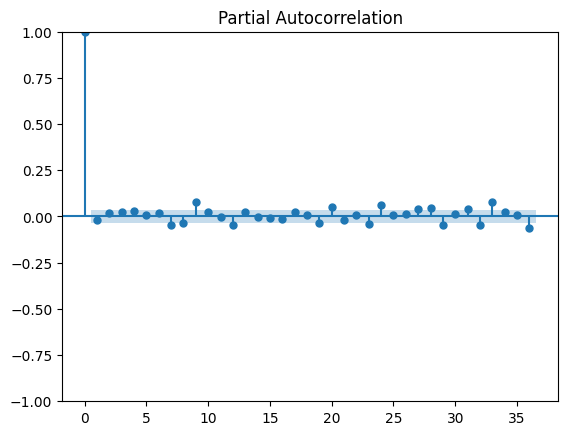

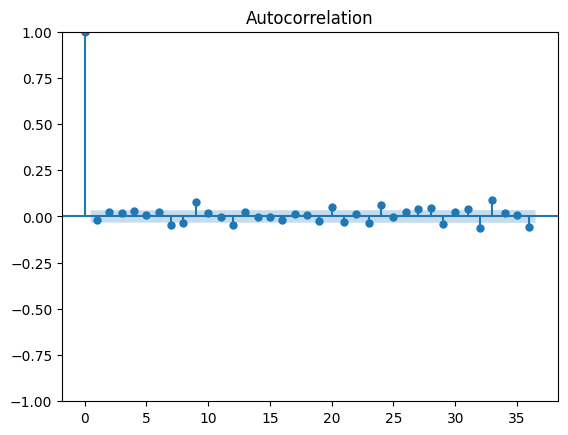

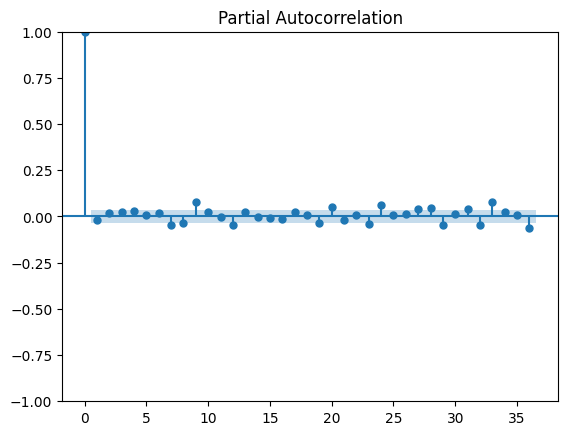

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_data['Close_diff'].dropna())
plot_pacf(merged_data['Close_diff'].dropna())


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(merged_data['Close'],
                order=(2,1,2),
                exog=merged_data['average_sentiment_score'],
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
num_future_steps = 5
future_dates = pd.date_range(start='2024-03-10', periods=num_future_steps)
future_sentiment_scores = [0.2, 0.15, 0.18, 0.1, 0.2]  # Hypothetical future sentiment scores


In [ ]:
forecast = results.forecast(steps=num_future_steps, exog=future_sentiment_scores)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Close', 'average_sentiment_score']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 0]  # We're predicting the closing price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # You can experiment with this value
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
87/87 [==============================] - 13s 50ms/step - loss: 0.0055 - val_loss: 7.7134e-04
Epoch 2/20
87/87 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 6.0828e-04
Epoch 3/20
87/87 [==============================] - 2s 25ms/step - loss: 0.0013 - val_loss: 6.0051e-04
Epoch 4/20
87/87 [==============================] - 3s 30ms/step - loss: 0.0013 - val_loss: 7.1016e-04
Epoch 5/20
87/87 [==============================] - 3s 35ms/step - loss: 0.0011 - val_loss: 6.5054e-04
Epoch 6/20
87/87 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/20
87/87 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 7.3007e-04
Epoch 8/20
87/87 [==============================] - 2s 24ms/step - loss: 8.8001e-04 - val_loss: 5.6281e-04
Epoch 9/20
87/87 [==============================] - 2s 24ms/step - loss: 8.7565e-04 - val_loss: 5.6299e-04
Epoch 10/20
87/87 [==============================] - 4s 42ms/step - 

In [ ]:
# Adjusted Evaluation
# Ensure that the test_data_scaled matches the length of the predictions
test_data_scaled = scaler.inverse_transform(scaled_data[train_size + seq_length + 1:])[:, 0]  # Adjusted slicing to match predictions length

# Ensure lengths match
assert len(predictions) == len(test_data_scaled), f"Length mismatch: predictions length is {len(predictions)}, but test_data_scaled length is {len(test_data_scaled)}"

# Calculate MSE
mse = np.mean(np.square(predictions - test_data_scaled))

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 8271194.9461195655


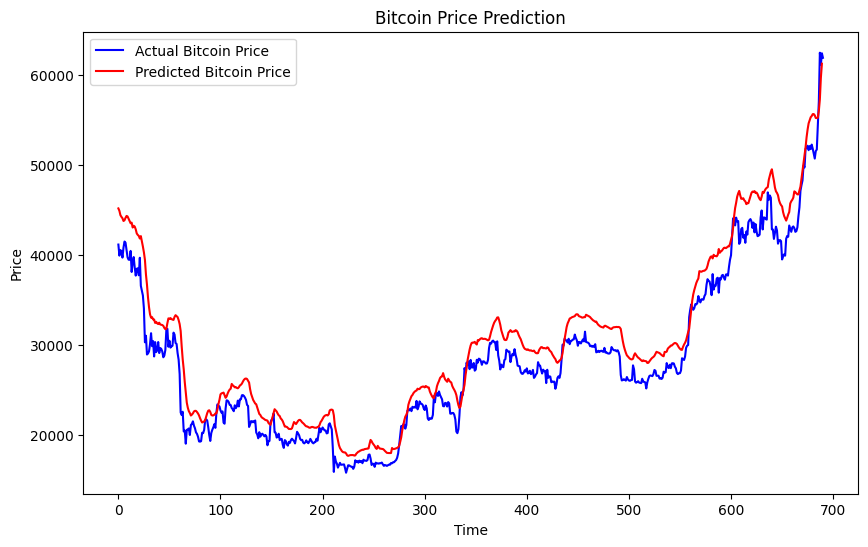

In [ ]:
import matplotlib.pyplot as plt

# Plotting the predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test_data_scaled, label='Actual Bitcoin Price', color='blue')  # Actual Prices
plt.plot(predictions, label='Predicted Bitcoin Price', color='red')  # Predicted Prices
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


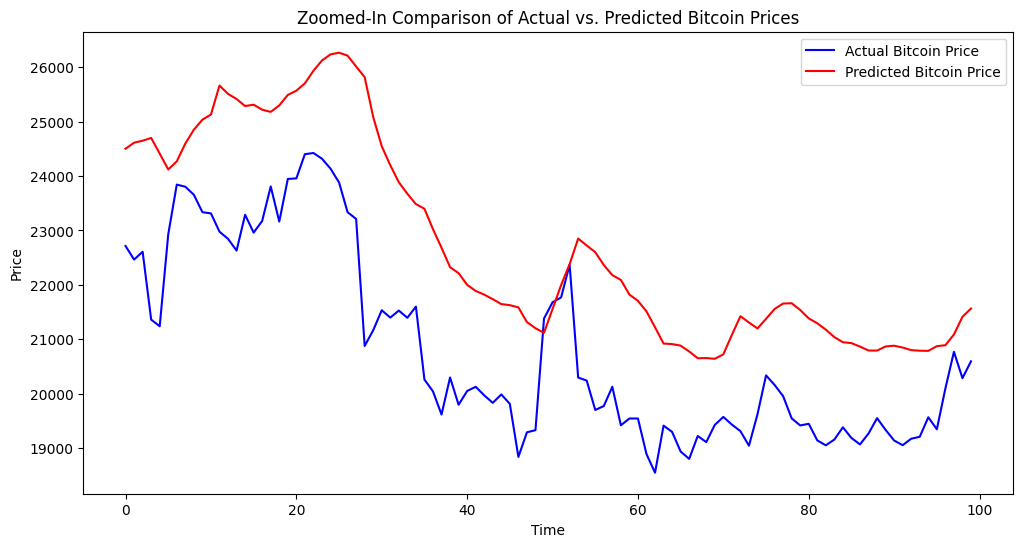

In [ ]:
import matplotlib.pyplot as plt

# Sample indices for zooming in. Adjust these based on your dataset and where you want to zoom in.
start_index = 100  # Start index of the zoomed-in view
end_index = 200    # End index of the zoomed-in view

plt.figure(figsize=(12, 6))
plt.plot(test_data_scaled[start_index:end_index], label='Actual Bitcoin Price', color='blue')
plt.plot(predictions[start_index:end_index], label='Predicted Bitcoin Price', color='red')
plt.title('Zoomed-In Comparison of Actual vs. Predicted Bitcoin Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
